In [6]:
import jax
import optax

from torch import Generator
from torch.utils.data import DataLoader, Subset

from specq_jax import core, data, model as specq_model
from exp_data_0020 import get_multi_drag_pulse_sequence

In [7]:
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = (
    data.load_data(
        "../../specq-experiment/datasets/0020",
        get_multi_drag_pulse_sequence,
        core.rotating_transmon_hamiltonian,
    )
)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [8]:
start_idx, end_idx = 0, 1500
batch_size = 150
MASTER_KEY_SEED = 0
g = Generator()
g.manual_seed(MASTER_KEY_SEED)

master_key = jax.random.PRNGKey(MASTER_KEY_SEED)
random_split_key, model_key, gate_optim_key = jax.random.split(master_key, 3)

# Final goal of setting up is to create a dataset and a dataloader
dataset = core.SpecQDataset(
    pulse_parameters=pulse_parameters[start_idx: end_idx],
    unitaries=unitaries[start_idx: end_idx],
    expectation_values=expectations[start_idx: end_idx],
)

# Randomly split dataset into training and validation
val_indices = jax.random.choice(
    random_split_key, len(dataset), (int(0.2 * len(dataset)),), replace=False
).tolist()

training_indices = list(
    set([i for i in range(len(dataset))]) - set(val_indices)
)

train_dataset = Subset(dataset, training_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=g)

model = specq_model.BasicBlackBox(feature_size=5)

warmup_start_lr, warmup_steps = 1e-6, 1000
start_lr, end_lr, steps = 1e-2, 1e-5, 10_000
lr_scheduler = optax.join_schedules(
    [
        optax.linear_schedule(
            warmup_start_lr,
            start_lr,
            warmup_steps,
        ),
        optax.linear_schedule(
            start_lr,
            end_lr,
            steps - warmup_steps,
        ),
    ],
    [warmup_steps],
)

optimiser = optax.adam(lr_scheduler)

train_step, test_step, model_params, opt_state = core.create_train_step(
    key=model_key,
    model=model,
    optimiser=optimiser,
    loss_fn=lambda params, pulse_parameters, unitaries, expectations: core.loss(
        params, pulse_parameters, unitaries, expectations, model
    ),
    input_shape=(batch_size, pulse_parameters.shape[1]),
)

In [9]:
model_params, opt_state, history = core.with_validation_train(
    train_dataloader,
    val_dataloader,
    train_step,
    test_step,
    model_params,
    opt_state,
)

on 0: /Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
        x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


|████████████████████████████████████████| 10000/10000 [100%] in 28.7s (348.82/s


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

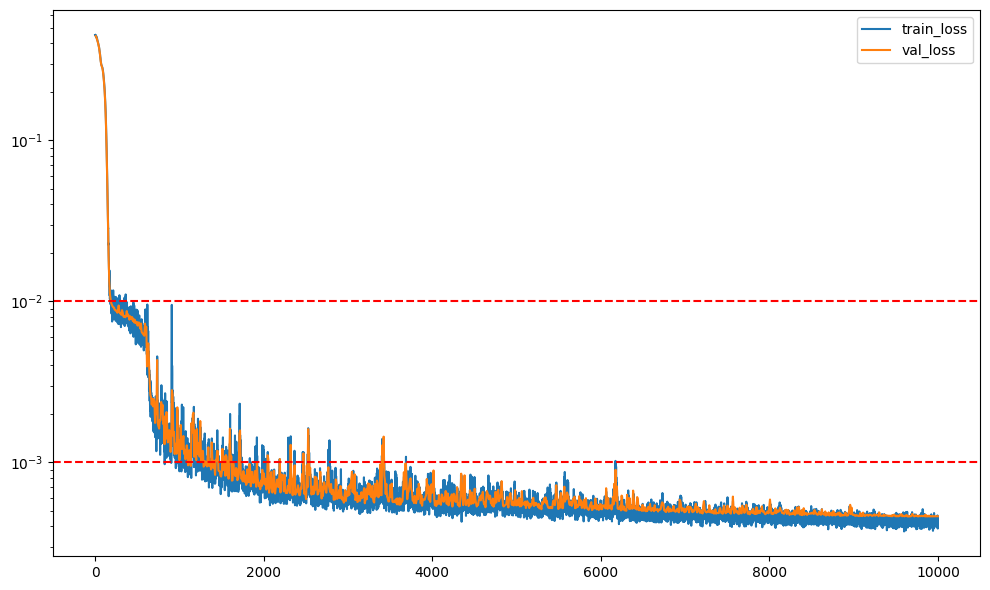

In [10]:
core.plot_history(history)